In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
try:
  # Disable all GPUS
  tf.config.set_visible_devices([], 'GPU')
  visible_devices = tf.config.get_visible_devices()
  for device in visible_devices:
    assert device.device_type != 'GPU'
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
import joblib
import keras
import matplotlib.pyplot as plt

In [3]:
TEST_DAYS = 50
PERIOD = '5y'

In [4]:
INDICATOR_DATASET = False

In [5]:
INCLUDE_COMMODITIES = True

In [6]:
if INDICATOR_DATASET:
    d = joblib.load('nifty_data.pkl')
else:
    d = yf.download(
                tickers="^NSEI",
                period=PERIOD,
                interval='1d',
                progress=False,
                timeout=10
            )
    if INCLUDE_COMMODITIES:
        gold = yf.download(
                    tickers="GC=F",
                    period=PERIOD,
                    interval='1d',
                    progress=False,
                    timeout=10
                ).add_prefix(prefix='gold_')
        crude = yf.download(
                    tickers="CL=F",
                    period=PERIOD,
                    interval='1d',
                    progress=False,
                    timeout=10
                ).add_prefix(prefix='crude_')
        d = pd.concat([d, gold, crude], axis=1)
    
    d['target'] = d.Open/d.Close.shift(-1)
    d.target = d.target.apply(np.floor)

    d['change'] = abs(d['Close'].pct_change(fill_method=None) * 100)

    d['High'] = d['High'].pct_change(fill_method=None) * 100
    d['Low'] = d['Low'].pct_change(fill_method=None) * 100
    d['Open'] = d['Open'].pct_change(fill_method=None) * 100
    d['Close'] = d['Close'].pct_change(fill_method=None) * 100 

    if INCLUDE_COMMODITIES:
        d['gold_High'] = d['gold_High'].pct_change(fill_method=None) * 100
        d['gold_Low'] = d['gold_Low'].pct_change(fill_method=None) * 100
        d['gold_Open'] = d['gold_Open'].pct_change(fill_method=None) * 100
        d['gold_Close'] = d['gold_Close'].pct_change(fill_method=None) * 100

        d['crude_High'] = d['crude_High'].pct_change(fill_method=None) * 100
        d['crude_Low'] = d['crude_Low'].pct_change(fill_method=None) * 100
        d['crude_Open'] = d['crude_Open'].pct_change(fill_method=None) * 100
        d['crude_Close'] = d['crude_Close'].pct_change(fill_method=None) * 100
    # d.rename(columns = {'HighNew':'High','LowNew':'Low','OpenNew':'Open','CloseNew':'Close'}, inplace = True)

    # Remove outliers when Market closes +- 3.5%
    d = d[d['change'] < 3]
    d.dropna(inplace=True)
    d.tail()

In [7]:
def preprocessBeforeScaling(df):
    df['High'] = df['High'].pct_change(fill_method=None) * 100
    df['Low'] = df['Low'].pct_change(fill_method=None) * 100
    df['Open'] = df['Open'].pct_change(fill_method=None) * 100
    df['Close'] = df['Close'].pct_change(fill_method=None) * 100 

    if INCLUDE_COMMODITIES:
        df['gold_High'] = df['gold_High'].pct_change(fill_method=None) * 100
        df['gold_Low'] = df['gold_Low'].pct_change(fill_method=None) * 100
        df['gold_Open'] = df['gold_Open'].pct_change(fill_method=None) * 100
        df['gold_Close'] = df['gold_Close'].pct_change(fill_method=None) * 100

        df['crude_High'] = df['crude_High'].pct_change(fill_method=None) * 100
        df['crude_Low'] = df['crude_Low'].pct_change(fill_method=None) * 100
        df['crude_Open'] = df['crude_Open'].pct_change(fill_method=None) * 100
        df['crude_Close'] = df['crude_Close'].pct_change(fill_method=None) * 100
    return df

In [8]:
test_dataset = d.tail(TEST_DAYS)

In [9]:
d = d[:-(TEST_DAYS+1)]

In [10]:
if INDICATOR_DATASET:
    x = d.drop(columns=['target'])
    y = d.target
else:
    if INCLUDE_COMMODITIES:
        # x = d.drop(columns=['target', 'Adj Close', 'Volume', 'change', 'gold_Adj Close', 'gold_Volume', 'crude_Adj Close', 'crude_Volume'], errors='ignore')
        x = d.drop(columns=['target', 'Adj Close', 'Volume', 'change', 'gold_Open', 'gold_High', 'gold_Low', 'gold_Adj Close', 'gold_Volume', 'crude_Open', 'crude_High', 'crude_Low', 'crude_Adj Close', 'crude_Volume'], errors='ignore')
    else:
        x = d.drop(columns=['target', 'Adj Close', 'Volume', 'change'], errors='ignore')
    y = d.target

In [11]:
x

,Open,High,Low,Close,gold_Close,crude_Close
Date,,,,,,
2018-11-19,0.819711,0.743793,0.542269,0.760145,0.188395,0.531348
2018-11-20,0.082466,-0.314167,-0.448602,-0.995970,-0.335212,-5.866804
2018-11-21,-0.643843,-0.647526,-0.737723,-0.526927,0.557838,2.245931
2018-11-27,0.502923,0.539121,1.016226,0.536289,-0.737584,-0.135579
2018-11-28,0.821920,0.585774,0.976751,0.404750,0.842146,-2.463151
...,...,...,...,...,...,...
2023-08-07,0.585984,0.417628,0.454566,0.411440,-0.314497,-1.062542
2023-08-08,0.257190,0.071105,0.042504,-0.134974,-0.486166,1.195992
2023-08-09,-0.246589,0.056531,-0.335838,0.315271,-0.452157,1.784857


In [12]:
y

Date
2018-11-19    1.0
2018-11-20    1.0
2018-11-21    1.0
2018-11-27    0.0
2018-11-28    0.0
             ... 
2023-08-07    1.0
2023-08-08    0.0
2023-08-09    1.0
2023-08-10    1.0
2023-08-11    1.0
Name: target, Length: 966, dtype: float64

In [13]:
print('No. of Bullish samples: {}'.format(y[y == 0].size))
print('No. of Bearish samples: {}'.format(y[y == 1].size))

No. of Bullish samples: 506
No. of Bearish samples: 460


In [14]:
if not INDICATOR_DATASET:
    print("Using StandardScaler")
    scaler = StandardScaler()
    x = scaler.fit_transform(x.to_numpy())
    x
else:
    print("Using ColumnTransformer")
    col_names = ['Open', 'High', 'Low', 'Close', 'ATR']
    scaler = ColumnTransformer(
        [('StandardScaler', StandardScaler(), col_names)],
        remainder='passthrough'
    )
    x = scaler.fit_transform(x)
x

Using StandardScaler


array([[ 6.58597736e-01,  8.04494879e-01,  4.51528068e-01,
         7.66463042e-01,  1.35910062e-01,  5.93388622e-02],
       [ 1.19662220e-02, -4.34193703e-01, -5.45172893e-01,
        -1.19559615e+00, -4.18790357e-01, -5.59228023e-01],
       [-6.25073637e-01, -8.24499116e-01, -8.35994774e-01,
        -6.71547487e-01,  5.27292121e-01,  2.25102944e-01],
       ...,
       [-2.76644732e-01, -1.69660885e-04, -4.31745390e-01,
         2.69417275e-01, -5.42680065e-01,  1.80526806e-01],
       [ 5.94709103e-02, -1.96879502e-01,  5.02297622e-02,
        -5.91885808e-01, -1.18981251e-01, -1.73018278e-01],
       [-2.89867741e-01, -4.59244766e-01, -5.20373755e-01,
        -7.39127604e-01, -1.46678952e-01,  5.11604994e-02]])

In [15]:
visible_devices

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [119]:
import tensorflow as tf
from keras import Sequential
from keras import Model
from keras.layers import Dense
from keras.optimizers import legacy, SGD
import keras

lr_list = []
def scheduler(epoch, lr):
    if epoch < 2:
        lr = lr
    else:
        lr = lr * tf.math.exp(-0.0025)
    lr_list.append(lr)
    return lr

units = 64 #128 #1024
# sgd = SGD(learning_rate=0.0001, momentum=0.0, nesterov=True)
sgd = legacy.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
kernel_init = 'he_uniform'
activation = 'relu'

callback_mc = keras.callbacks.ModelCheckpoint(
                'best_model.h5',
                verbose=1,
                monitor='val_accuracy',
                save_best_only=True,
                mode='auto'
                )
callback_es = keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                mode='auto',
                verbose=0,
                patience=100
)
callback_lr = keras.callbacks.LearningRateScheduler(scheduler)

model = Sequential([
    Dense(units, kernel_initializer=kernel_init, activation=activation, input_dim=x.shape[1]),
    # Dense(units, kernel_initializer=kernel_init, activation=activation),
    Dense(units//2, kernel_initializer=kernel_init, activation=activation),
    Dense(units//4, kernel_initializer=kernel_init, activation=activation),
    Dense(units//8, kernel_initializer=kernel_init, activation=activation),
    Dense(units//16, kernel_initializer=kernel_init, activation=activation),
    Dense(units//32, kernel_initializer=kernel_init, activation=activation),
    Dense(1, kernel_initializer=kernel_init, activation='sigmoid'),
])
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_140 (Dense)           (None, 64)                448       
                                                                 
 dense_141 (Dense)           (None, 32)                2080      
                                                                 
 dense_142 (Dense)           (None, 16)                528       
                                                                 
 dense_143 (Dense)           (None, 8)                 136       
                                                                 
 dense_144 (Dense)           (None, 4)                 36        
                                                                 
 dense_145 (Dense)           (None, 2)                 10        
                                                                 
 dense_146 (Dense)           (None, 1)               

In [120]:
BATCH_SIZE = int(len(y)/6.6125) #128 #24 #4
BATCH_SIZE = 256
print(f'BATCH SIZE = {BATCH_SIZE}')
history = model.fit(x, y, callbacks=[callback_mc, callback_es, callback_lr], batch_size=BATCH_SIZE, epochs=750, validation_split=0.15, verbose=2)

BATCH SIZE = 256
Epoch 1/750

Epoch 1: val_accuracy improved from -inf to 0.46207, saving model to best_model.h5
4/4 - 0s - loss: 0.6894 - accuracy: 0.5347 - val_loss: 0.7032 - val_accuracy: 0.4621 - lr: 0.0010 - 258ms/epoch - 64ms/step
Epoch 2/750

Epoch 2: val_accuracy did not improve from 0.46207
4/4 - 0s - loss: 0.6886 - accuracy: 0.5347 - val_loss: 0.7032 - val_accuracy: 0.4621 - lr: 0.0010 - 15ms/epoch - 4ms/step
Epoch 3/750

Epoch 3: val_accuracy did not improve from 0.46207
4/4 - 0s - loss: 0.6874 - accuracy: 0.5347 - val_loss: 0.7030 - val_accuracy: 0.4621 - lr: 9.9750e-04 - 14ms/epoch - 4ms/step
Epoch 4/750

Epoch 4: val_accuracy did not improve from 0.46207
4/4 - 0s - loss: 0.6854 - accuracy: 0.5347 - val_loss: 0.7024 - val_accuracy: 0.4621 - lr: 9.9501e-04 - 15ms/epoch - 4ms/step
Epoch 5/750

Epoch 5: val_accuracy did not improve from 0.46207
4/4 - 0s - loss: 0.6826 - accuracy: 0.5347 - val_loss: 0.7017 - val_accuracy: 0.4621 - lr: 9.9253e-04 - 14ms/epoch - 4ms/step
Epoch 6

/Users/pranjaljoshi/miniforge3/envs/screenipy/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 - 0s - loss: 0.6584 - accuracy: 0.5347 - val_loss: 0.6979 - val_accuracy: 0.6069 - lr: 9.7287e-04 - 38ms/epoch - 10ms/step
Epoch 14/750

Epoch 14: val_accuracy did not improve from 0.60690
4/4 - 0s - loss: 0.6563 - accuracy: 0.6590 - val_loss: 0.6973 - val_accuracy: 0.6069 - lr: 9.7045e-04 - 17ms/epoch - 4ms/step
Epoch 15/750

Epoch 15: val_accuracy improved from 0.60690 to 0.61379, saving model to best_model.h5
4/4 - 0s - loss: 0.6544 - accuracy: 0.6565 - val_loss: 0.6967 - val_accuracy: 0.6138 - lr: 9.6802e-04 - 21ms/epoch - 5ms/step
Epoch 16/750

Epoch 16: val_accuracy did not improve from 0.61379
4/4 - 0s - loss: 0.6526 - accuracy: 0.6577 - val_loss: 0.6962 - val_accuracy: 0.6138 - lr: 9.6561e-04 - 15ms/epoch - 4ms/step
Epoch 17/750

Epoch 17: val_accuracy did not improve from 0.61379
4/4 - 0s - loss: 0.6510 - accuracy: 0.6590 - val_loss: 0.6956 - val_accuracy: 0.6138 - lr: 9.6319e-04 - 15ms/epoch - 4ms/step
Epoch 18/750

Epoch 18: val_accuracy improved from 0.61379 to 0.62069,

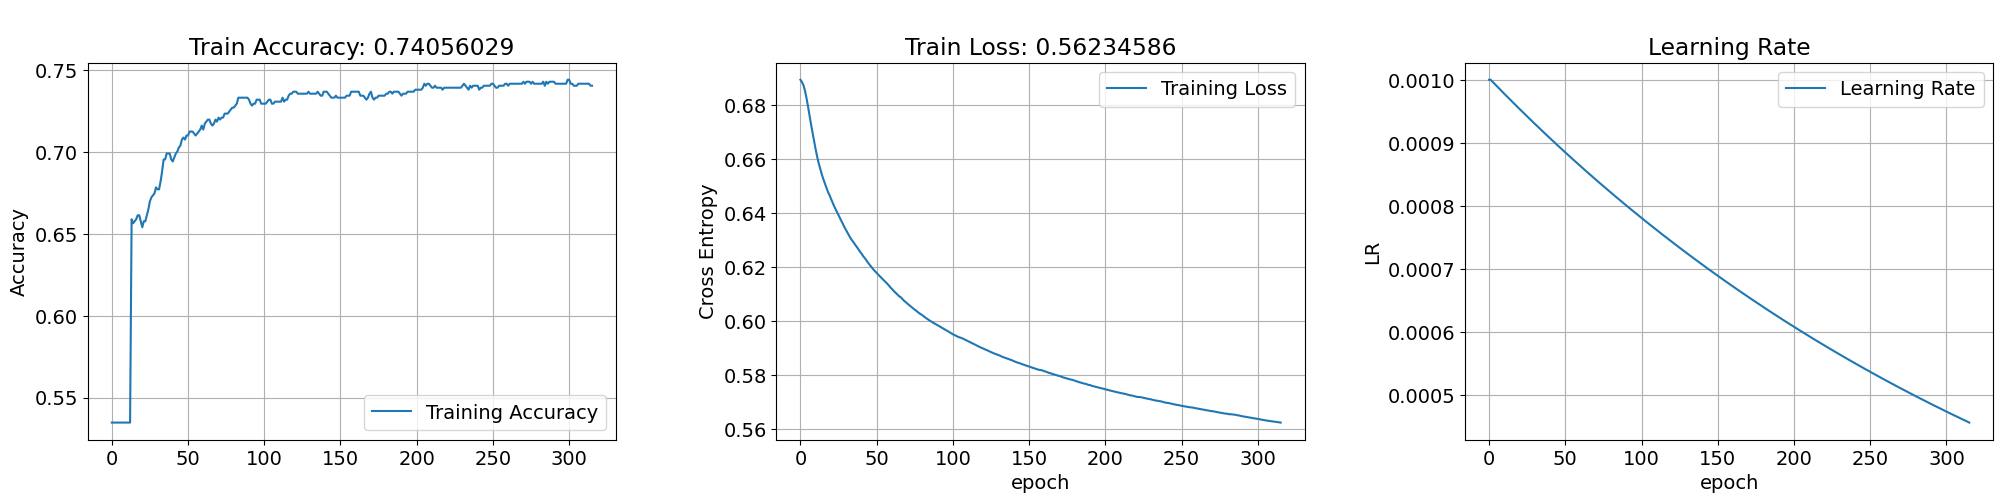

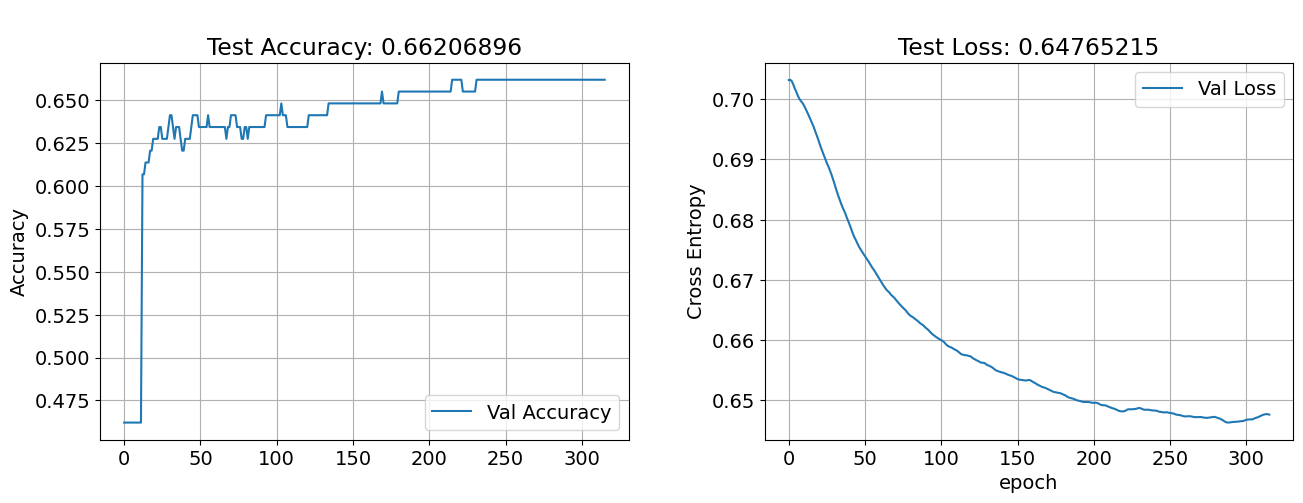

In [121]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']

plt.figure(figsize=(21,6))
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'

plt.subplot(1, 3, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTrain Accuracy: {round(acc[-1],8)}')

plt.subplot(1, 3, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'\nTrain Loss: {round(loss[-1],8)}')
plt.xlabel('epoch')

plt.subplot(1, 3, 3)
plt.plot(lr_list, label='Learning Rate')
plt.legend(loc='upper right')
plt.ylabel('LR')
plt.title(f'\nLearning Rate')
plt.xlabel('epoch')

plt.tight_layout(pad=3.0)
plt.show()

acc = history.history['val_accuracy']
loss = history.history['val_loss']

plt.figure(figsize=(14,6))
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(1, 2, 1)
plt.plot(acc, label='Val Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTest Accuracy: {round(acc[-1],8)}')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Val Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'\nTest Loss: {round(loss[-1],8)}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

## Try Realtime Inference

In [124]:
metrics = {
    "TP": 0, "FP": 0, "TN": 0, "FN": 0
}

In [126]:
endpoint = keras.models.load_model('nifty_model_v3.h5')
# endpoint = keras.models.load_model('best_model.h5')
try:
    scaler
except NameError:
    pkl = joblib.load('nifty_model.pkl')
    scaler = pkl['scaler']
today = yf.download(
                tickers="^NSEI",
                period=f'{TEST_DAYS}d',
                interval='1d',
                progress=False,
                timeout=10
            )
if INCLUDE_COMMODITIES:
    gold = yf.download(
                    tickers="GC=F",
                    period=f'{TEST_DAYS}d',
                    interval='1d',
                    progress=False,
                    timeout=10
                ).add_prefix(prefix='gold_')
    crude = yf.download(
                tickers="CL=F",
                period=f'{TEST_DAYS}d',
                interval='1d',
                progress=False,
                timeout=10
            ).add_prefix(prefix='crude_')

    today = pd.concat([today, gold, crude], axis=1)
    today = today.drop(columns=['Adj Close', 'Volume', 'gold_Adj Close', 'gold_Volume', 'crude_Adj Close', 'crude_Volume'])
else:
    today = today.drop(columns=['Adj Close', 'Volume'])

###
today = preprocessBeforeScaling(today)
today = today.drop(columns=['gold_Open', 'gold_High', 'gold_Low', 'crude_Open', 'crude_High', 'crude_Low'])
###

cnt_correct, cnt_wrong = 0, 0
for i in range(-TEST_DAYS,0):
    df = today.iloc[i]
    twr = today.iloc[i+1]['Close']
    df = scaler.transform([df])
    pred = endpoint.predict([df], verbose=0)

    if twr > today.iloc[i]['Open']:
        fact = "BULLISH"
    else:
        fact = "BEARISH"

    if pred > 0.5:
        out = "BEARISH"
    else:
        out = "BULLISH"

    if out == fact:
        cnt_correct += 1
        if out == "BULLISH":
            metrics["TP"] += 1
        else:
            metrics["TN"] += 1
    else:
        cnt_wrong += 1
        if out == "BULLISH":
            metrics["FN"] += 1
        else:
            metrics["FP"] += 1

        
    print("{} Nifty Prediction -> Market may Close {} on {}! Actual -> {}, Prediction -> {}, Pred = {}".format(
            today.iloc[i].name.strftime("%d-%m-%Y"),
            out,
            (today.iloc[i].name + pd.Timedelta(days=1)).strftime("%d-%m-%Y"),
            fact,
            "Correct" if fact == out else "Wrong",
            str(np.round(pred[0][0], 2))
            )
        )

print("Correct: {}, Wrong: {}, Accuracy: {}".format(cnt_correct, cnt_wrong, cnt_correct/(cnt_correct+cnt_wrong)))
print(metrics)

07-09-2023 Nifty Prediction -> Market may Close BULLISH on 08-09-2023! Actual -> BULLISH, Prediction -> Correct, Pred = nan
08-09-2023 Nifty Prediction -> Market may Close BULLISH on 09-09-2023! Actual -> BEARISH, Prediction -> Wrong, Pred = nan
11-09-2023 Nifty Prediction -> Market may Close BULLISH on 12-09-2023! Actual -> BEARISH, Prediction -> Wrong, Pred = nan
12-09-2023 Nifty Prediction -> Market may Close BULLISH on 13-09-2023! Actual -> BEARISH, Prediction -> Wrong, Pred = nan
13-09-2023 Nifty Prediction -> Market may Close BULLISH on 14-09-2023! Actual -> BULLISH, Prediction -> Correct, Pred = nan
14-09-2023 Nifty Prediction -> Market may Close BULLISH on 15-09-2023! Actual -> BEARISH, Prediction -> Wrong, Pred = nan
15-09-2023 Nifty Prediction -> Market may Close BULLISH on 16-09-2023! Actual -> BEARISH, Prediction -> Wrong, Pred = nan
18-09-2023 Nifty Prediction -> Market may Close BULLISH on 19-09-2023! Actual -> BEARISH, Prediction -> Wrong, Pred = nan
20-09-2023 Nifty Pre

## Save Model for Screeni-py integration

In [127]:
pkl = {
    #  'model': model,
    'scaler': scaler,
    'columns': ['Open', 'Close', 'High', 'Low', 'gold_Close', 'crude_Close']
}

joblib.dump(pkl, 'nifty_model.pkl')

['nifty_model.pkl']

In [128]:
pkl = joblib.load('nifty_model_v3.pkl')
z = yf.download(
                tickers="^NSEI",
                period='5d',
                interval='1d',
                progress=False,
                timeout=10
            )
if INCLUDE_COMMODITIES:
    gold = yf.download(
                tickers="GC=F",
                period='5d',
                interval='1d',
                progress=False,
                timeout=10
            ).add_prefix(prefix='gold_')
    crude = yf.download(
                tickers="CL=F",
                period='5d',
                interval='1d',
                progress=False,
                timeout=10
            ).add_prefix(prefix='crude_')
    z = pd.concat([z, gold, crude], axis=1)
z = preprocessBeforeScaling(z)
z = z.iloc[-1]
z = z[pkl['columns']]
print(z)
z = pkl['scaler'].transform([z])
endpoint.predict(z)

Open           0.118561
Close          0.646497
High           0.608594
Low            0.241831
gold_Close     0.397941
crude_Close   -1.174017
Name: 2023-11-16 00:00:00, dtype: float64
1/1 [==============================] - 0s 40ms/step


array([[0.4365444]], dtype=float32)

In [ ]:
pkl['model'].save('nifty_model.h5')

In [ ]:
pkl

In [ ]:
del pkl['model']

In [ ]:
pkl

In [ ]:
def getSigmoidConfidence(x):
    out_min, out_max = 0, 100
    if x > 0.5:
        in_min = 0.50001
        in_max = 1
    else:
        in_min = 0
        in_max = 0.5
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

map_range(0.9633487, 0.5, 1, 0, 100)